# Example using the NN Ensemble class

This is a simple/silly example using an existing NN surrogate of the LCLS injector showing how to set up a NN ensemble in lume-model.

The surrogate can be installed from [https://github.com/slaclab/lcls_cu_injector_ml_model](https://github.com/slaclab/lcls_cu_injector_ml_model)



In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from lume_model.utils import variables_from_yaml
from lume_model.models import TorchModel
from lume_model.models.ensemble import NNEnsemble
from lume_model.variables import DistributionVariable

## Create model

In [2]:
# load transformers
input_sim_to_nn = torch.load("model/input_sim_to_nn.pt", weights_only=False)
output_sim_to_nn = torch.load("model/output_sim_to_nn.pt", weights_only=False)

In [3]:
# load in- and output variable specification
input_variables, output_variables = variables_from_yaml("model/sim_variables.yml")

In [4]:
# Get example inputs ready for test
inputs_small = torch.load("info/inputs_small.pt", weights_only=False)
outputs_small = torch.load("info/outputs_small.pt", weights_only=False)

input_dict = {}
for i, n in enumerate(input_variables):
    input_dict[n.name] = inputs_small[:,i]

## Create a wrapper around the model to add some random noise to the outputs

Note that without this, since our ensemble is all the same NN, the variance would be zero and the output distribution instantiation would throw an error.

In [5]:
class NoisyLCLSSurrogate(TorchModel):
    """Dumb class to create noisy/variable output
    for the LCLS surrogate model"""
    noise_level: float = 0.01
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _evaluate(self, input_dict):
        # Add random noise to output
        output_dict = super()._evaluate(input_dict)
        noise = np.random.normal(0, self.noise_level)
        output_dict_noisy = {n: t + t*noise  for n,t in output_dict.items()}
        return output_dict_noisy

In [6]:
noisy_model = NoisyLCLSSurrogate(
    model="model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_sim_to_nn],
    output_transformers=[output_sim_to_nn]
)

Loaded PyTorch model from file: Sequential(
  (0): Linear(in_features=16, out_features=100, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=100, out_features=200, bias=True)
  (3): ELU(alpha=1.0)
  (4): Dropout(p=0.05, inplace=False)
  (5): Linear(in_features=200, out_features=200, bias=True)
  (6): ELU(alpha=1.0)
  (7): Dropout(p=0.05, inplace=False)
  (8): Linear(in_features=200, out_features=300, bias=True)
  (9): ELU(alpha=1.0)
  (10): Dropout(p=0.05, inplace=False)
  (11): Linear(in_features=300, out_features=300, bias=True)
  (12): ELU(alpha=1.0)
  (13): Dropout(p=0.05, inplace=False)
  (14): Linear(in_features=300, out_features=200, bias=True)
  (15): ELU(alpha=1.0)
  (16): Dropout(p=0.05, inplace=False)
  (17): Linear(in_features=200, out_features=100, bias=True)
  (18): ELU(alpha=1.0)
  (19): Dropout(p=0.05, inplace=False)
  (20): Linear(in_features=100, out_features=100, bias=True)
  (21): ELU(alpha=1.0)
  (22): Linear(in_features=100, out_features=100, bias=True)


## Create ensemble

In [7]:
models_list = [noisy_model]*10
ensemble_output_variables = [
 DistributionVariable(name='sigma_x', distribution_type="Normal"),
 DistributionVariable(name='sigma_y', distribution_type="Normal"),
 DistributionVariable(name='sigma_z', distribution_type="Normal"),
 DistributionVariable(name='norm_emit_x', distribution_type="Normal"),
 DistributionVariable(name='norm_emit_y', distribution_type="Normal")
]

nn_ensemble = NNEnsemble(models=models_list, input_variables=input_variables, output_variables=ensemble_output_variables)

## Test on example data

In [8]:
ensemble_out = nn_ensemble.evaluate(input_dict)

In [9]:
ensemble_out

{'sigma_x': Normal(loc: torch.Size([283]), scale: torch.Size([283])),
 'sigma_y': Normal(loc: torch.Size([283]), scale: torch.Size([283])),
 'sigma_z': Normal(loc: torch.Size([283]), scale: torch.Size([283])),
 'norm_emit_x': Normal(loc: torch.Size([283]), scale: torch.Size([283])),
 'norm_emit_y': Normal(loc: torch.Size([283]), scale: torch.Size([283]))}

In [10]:
for k, v in ensemble_out.items():
    print(k, v.mean[0], v.variance[0]) # example mean/var for first sample of all outputs

sigma_x tensor(0.0002) tensor(4.0734e-12)
sigma_y tensor(0.0014) tensor(2.6775e-10)
sigma_z tensor(0.0005) tensor(3.7644e-11)
norm_emit_x tensor(1.4083e-06) tensor(2.5715e-16)
norm_emit_y tensor(1.1879e-06) tensor(1.8296e-16)


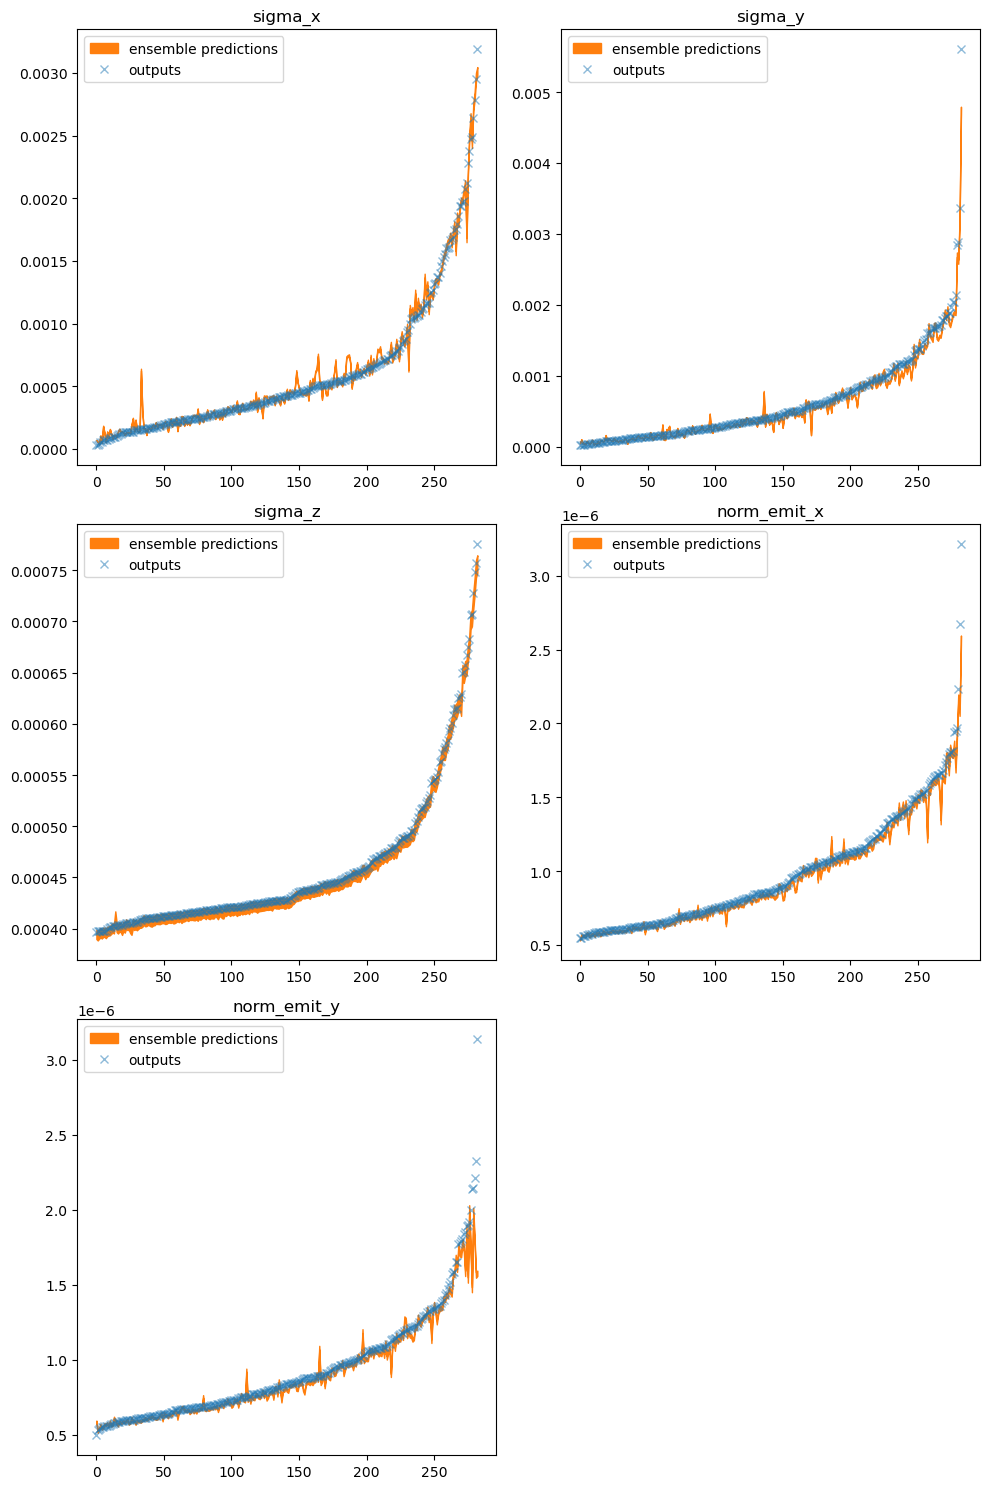

In [11]:
# plot example data and predictions
nrows, ncols = 3, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 15))
for i, output_name in enumerate(nn_ensemble.output_names):
    ax_i = ax[i // ncols, i % ncols]
    if i < outputs_small.shape[1]:
        sort_idx = torch.argsort(outputs_small[:, i])
        x_axis = torch.arange(outputs_small.shape[0])
        lower = ensemble_out[output_name].mean[sort_idx] - torch.sqrt(ensemble_out[output_name].variance[sort_idx])
        upper = ensemble_out[output_name].mean[sort_idx] + torch.sqrt(ensemble_out[output_name].variance[sort_idx])
        ax_i.fill_between(x=x_axis, y1=lower, y2=upper, color="C1", label="ensemble predictions")
        ax_i.plot(x_axis, outputs_small[sort_idx, i], "C0x", label="outputs", alpha=0.5)
        ax_i.legend()
        ax_i.set_title(output_name)
ax[-1, -1].axis('off')
fig.tight_layout()